In [4]:
# Constants

LEARNING_RATE = 0.05
NUM_ITER = 2048
TARGET_CLASS = 1   # goldfish

ROTATION_DEG = 5
IMG_HEIGHT, IMG_WIDTH = 224, 224
JITTER_PX = 16
SCALE_FACTOR = 0.2

In [5]:
# Imports and Model

import torchvision.models as models
from torchvision.models import AlexNet_Weights
from torchvision.transforms import v2
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

model = models.alexnet(weights = AlexNet_Weights.IMAGENET1K_V1)
model.eval()
preprocess = AlexNet_Weights.IMAGENET1K_V1.transforms()

In [ ]:
# Naive

image = torch.rand((1, 3, IMG_HEIGHT, IMG_WIDTH), requires_grad = True)
optimizer = torch.optim.Adam([image], lr = LEARNING_RATE)

for i in range(NUM_ITER):
  optimizer.zero_grad()
  preprocessed_image = preprocess(image)

  out = model(preprocessed_image)

  loss = -out[0, TARGET_CLASS]
  loss.backward()
  optimizer.step()

  with torch.no_grad():
    image.data.clamp_(0, 1)

  if (i + 1) % 10 == 0:
    print(f"Iteration {i + 1}/{NUM_ITER}: Loss: {loss.item()}")

final_image = image.detach().clone().squeeze(0)
plt.imshow(TF.to_pil_image(final_image))
plt.title(f"Optimized for class {TARGET_CLASS}")
plt.show()


Iteration 10/2048: Loss: -3.8013432025909424
Iteration 20/2048: Loss: -12.370943069458008
Iteration 30/2048: Loss: -32.72753143310547
Iteration 40/2048: Loss: -43.239768981933594
Iteration 50/2048: Loss: -70.23497772216797
Iteration 60/2048: Loss: -74.50591278076172
Iteration 70/2048: Loss: -85.2527847290039
Iteration 80/2048: Loss: -99.82523345947266
Iteration 90/2048: Loss: -107.3902359008789
Iteration 100/2048: Loss: -134.95025634765625
Iteration 110/2048: Loss: -106.82513427734375
Iteration 120/2048: Loss: -126.76702117919922
Iteration 130/2048: Loss: -101.73661041259766
Iteration 140/2048: Loss: -147.5691680908203
Iteration 150/2048: Loss: -141.1144561767578
Iteration 160/2048: Loss: -158.4508514404297
Iteration 170/2048: Loss: -153.3959503173828
Iteration 180/2048: Loss: -174.56063842773438
Iteration 190/2048: Loss: -157.5188446044922
Iteration 200/2048: Loss: -160.3399658203125
Iteration 210/2048: Loss: -195.13063049316406
Iteration 220/2048: Loss: -211.2136993408203
Iteration 2

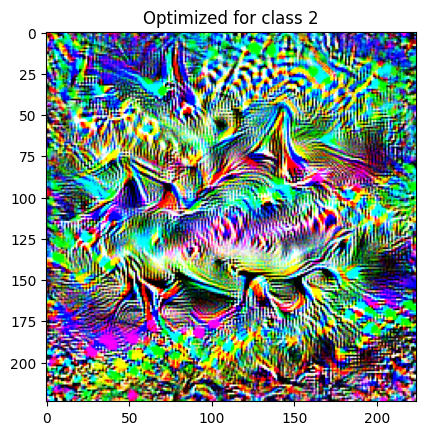

In [ ]:
# Transformation Robustness

image = torch.rand((1, 3, IMG_HEIGHT, IMG_WIDTH), requires_grad = True)
optimizer = torch.optim.Adam([image], lr = LEARNING_RATE)

transforms = v2.Compose([
    v2.Pad(padding = JITTER_PX),
    v2.RandomCrop(size = (IMG_HEIGHT, IMG_WIDTH)),
    v2.RandomResizedCrop(size = (IMG_HEIGHT, IMG_WIDTH), scale = (1-SCALE_FACTOR, 1)),
    v2.RandomRotation(ROTATION_DEG)
])

for i in range(NUM_ITER):
  optimizer.zero_grad()

  transformed_image = transforms(image.clone())

  preprocessed_image = preprocess(transformed_image)

  out = model(preprocessed_image)

  loss = -out[0, TARGET_CLASS]
  loss.backward()
  optimizer.step()

  with torch.no_grad():
    image.data.clamp_(0, 1)

  if (i + 1) % 10 == 0:
    print(f"Iteration {i + 1}/{NUM_ITER}: Loss: {loss.item()}")

final_image = image.detach().clone().squeeze(0)
plt.imshow(TF.to_pil_image(final_image))
plt.title(f"Optimized for class {TARGET_CLASS}")
plt.show()


Iteration 10/2048: Loss: -25.916040420532227
Iteration 20/2048: Loss: -86.83161926269531
Iteration 30/2048: Loss: -154.28529357910156
Iteration 40/2048: Loss: -217.31459045410156
Iteration 50/2048: Loss: -276.9068298339844
Iteration 60/2048: Loss: -335.5114440917969
Iteration 70/2048: Loss: -391.3697509765625
Iteration 80/2048: Loss: -442.8868103027344
Iteration 90/2048: Loss: -487.2557678222656
Iteration 100/2048: Loss: -525.2617797851562
Iteration 110/2048: Loss: -557.5006713867188
Iteration 120/2048: Loss: -584.710693359375
Iteration 130/2048: Loss: -607.5637817382812
Iteration 140/2048: Loss: -627.1206665039062
Iteration 150/2048: Loss: -644.9772338867188
Iteration 160/2048: Loss: -660.4838256835938
Iteration 170/2048: Loss: -673.9688110351562
Iteration 180/2048: Loss: -685.6566772460938
Iteration 190/2048: Loss: -696.3689575195312
Iteration 200/2048: Loss: -705.8323364257812
Iteration 210/2048: Loss: -714.3899536132812
Iteration 220/2048: Loss: -722.28857421875
Iteration 230/2048:

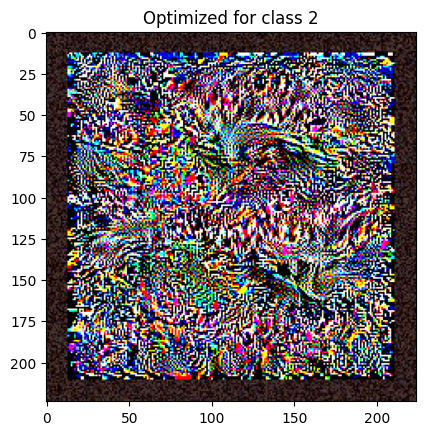

In [3]:
# Decorrelation

# color correlation matrix for imagenet
# https://github.com/tensorflow/lucid/blob/master/lucid/optvis/param/color.py
LUCID_COLOR_CORRELATION = torch.tensor([
    [0.26, 0.09, 0.02],
    [0.27, 0.00, -0.05],
    [0.27, -0.09, 0.03]
]).T

def correlate_image(image):
  permute_image = image.permute((0, 2, 3, 1))
  corr_image = torch.einsum("abcd, de -> abce", permute_image, LUCID_COLOR_CORRELATION)
  return corr_image.permute((0, 3, 1, 2)).clamp(0, 1)

image = torch.rand((1, 3, IMG_HEIGHT, IMG_WIDTH), requires_grad = True)
optimizer = torch.optim.Adam([image], lr = LEARNING_RATE)

for i in range(NUM_ITER):
  optimizer.zero_grad()

  corr_image = correlate_image(image)

  preprocessed_image = preprocess(corr_image)

  out = model(preprocessed_image)

  loss = -out[0, TARGET_CLASS]
  loss.backward()
  optimizer.step()

  if (i + 1) % 10 == 0:
    print(f"Iteration {i + 1}/{NUM_ITER}: Loss: {loss.item()}")

final_image = image.detach().clone()
final_corr_image = correlate_image(final_image).squeeze(0)
plt.imshow(TF.to_pil_image(final_corr_image))
plt.title(f"Optimized for class {TARGET_CLASS}")
plt.show()

Iteration 10/2048: Loss: -5.177751064300537
Iteration 20/2048: Loss: -16.716217041015625
Iteration 30/2048: Loss: -27.25275993347168
Iteration 40/2048: Loss: -43.603797912597656
Iteration 50/2048: Loss: -56.49113082885742
Iteration 60/2048: Loss: -68.95219421386719
Iteration 70/2048: Loss: -85.53591918945312
Iteration 80/2048: Loss: -92.17707824707031
Iteration 90/2048: Loss: -107.67208099365234
Iteration 100/2048: Loss: -103.90972137451172
Iteration 110/2048: Loss: -136.2360382080078
Iteration 120/2048: Loss: -141.9557342529297
Iteration 130/2048: Loss: -160.38572692871094
Iteration 140/2048: Loss: -162.45635986328125
Iteration 150/2048: Loss: -175.7483367919922
Iteration 160/2048: Loss: -193.19070434570312
Iteration 170/2048: Loss: -193.8102569580078
Iteration 180/2048: Loss: -179.74815368652344
Iteration 190/2048: Loss: -204.3734893798828
Iteration 200/2048: Loss: -192.0409698486328
Iteration 210/2048: Loss: -209.7061309814453
Iteration 220/2048: Loss: -207.09190368652344
Iteration 

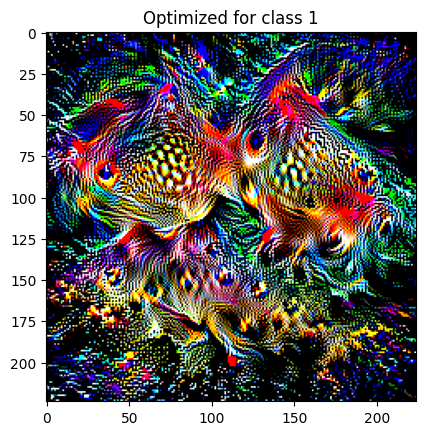

In [6]:
# Decorrelation + Transformation Robustness

image = torch.rand((1, 3, IMG_HEIGHT, IMG_WIDTH), requires_grad = True)
optimizer = torch.optim.Adam([image], lr = LEARNING_RATE)

# color correlation matrix for imagenet
# https://github.com/tensorflow/lucid/blob/master/lucid/optvis/param/color.py
LUCID_COLOR_CORRELATION = torch.tensor([
    [0.26, 0.09, 0.02],
    [0.27, 0.00, -0.05],
    [0.27, -0.09, 0.03]
]).T

def correlate_image(image):
  permute_image = image.permute((0, 2, 3, 1))
  corr_image = torch.einsum("abcd, de -> abce", permute_image, LUCID_COLOR_CORRELATION)
  return corr_image.permute((0, 3, 1, 2)).clamp(0, 1)

transforms = v2.Compose([
    v2.Pad(padding = JITTER_PX),
    v2.RandomCrop(size = (IMG_HEIGHT, IMG_WIDTH)),
    v2.RandomResizedCrop(size = (IMG_HEIGHT, IMG_WIDTH), scale = (1-SCALE_FACTOR, 1)),
    v2.RandomRotation(ROTATION_DEG)
])

for i in range(NUM_ITER):
  optimizer.zero_grad()

  corr_image = correlate_image(image)

  transformed_image = transforms(corr_image.clone())

  preprocessed_image = preprocess(transformed_image)

  out = model(preprocessed_image)

  loss = -out[0, TARGET_CLASS]
  loss.backward()
  optimizer.step()

  if (i + 1) % 10 == 0:
    print(f"Iteration {i + 1}/{NUM_ITER}: Loss: {loss.item()}")

final_image = image.detach().clone()
final_corr_image = correlate_image(final_image).squeeze(0)
plt.imshow(TF.to_pil_image(final_corr_image))
plt.title(f"Optimized for class {TARGET_CLASS}")
plt.show()